In [29]:
pip install pandas scikit-learn xgboost joblib


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# === 1. Load Data ===
df = pd.read_csv('/content/IoTProcessed_Data.csv')  # Replace with your dataset path

# === 2. Preprocess ===
df = df.drop(columns=['date', 'Fan_actuator_OFF', 'Watering_plant_pump_OFF', 'Water_pump_actuator_OFF', 'Water_pump_actuator_ON'])

# Features (X) and labels (y)
X = df.drop(columns=['Fan_actuator_ON', 'Watering_plant_pump_ON'])
y = df[['Fan_actuator_ON', 'Watering_plant_pump_ON']]

# === 3. Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4. Train Random Forest ===
print("\n🌲 Training Random Forest...")
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\n📊 Random Forest Performance:")
print(classification_report(y_test, rf_preds, target_names=['Fan_actuator_ON', 'Watering_plant_pump_ON']))

# Save Random Forest model
joblib.dump(rf_model, 'rf_greenhouse_model.pkl')

# === 5. Train XGBoost ===
print("\n🚀 Training XGBoost...")
xgb_base = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model = MultiOutputClassifier(xgb_base)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("\n📊 XGBoost Performance:")
print(classification_report(y_test, xgb_preds, target_names=['Fan_actuator_ON', 'Watering_plant_pump_ON']))

# Save XGBoost model
joblib.dump(xgb_model, 'xgb_greenhouse_model.pkl')

print("\n✅ Models saved as 'rf_greenhouse_model.pkl' and 'xgb_greenhouse_model.pkl'")



🌲 Training Random Forest...

📊 Random Forest Performance:
                        precision    recall  f1-score   support

       Fan_actuator_ON       1.00      1.00      1.00      2338
Watering_plant_pump_ON       1.00      1.00      1.00      1757

             micro avg       1.00      1.00      1.00      4095
             macro avg       1.00      1.00      1.00      4095
          weighted avg       1.00      1.00      1.00      4095
           samples avg       0.44      0.44      0.44      4095


🚀 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/tr


📊 XGBoost Performance:
                        precision    recall  f1-score   support

       Fan_actuator_ON       1.00      1.00      1.00      2338
Watering_plant_pump_ON       1.00      1.00      1.00      1757

             micro avg       1.00      1.00      1.00      4095
             macro avg       1.00      1.00      1.00      4095
          weighted avg       1.00      1.00      1.00      4095
           samples avg       0.44      0.44      0.44      4095


✅ Models saved as 'rf_greenhouse_model.pkl' and 'xgb_greenhouse_model.pkl'


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:50:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

In [31]:
pip install shap matplotlib


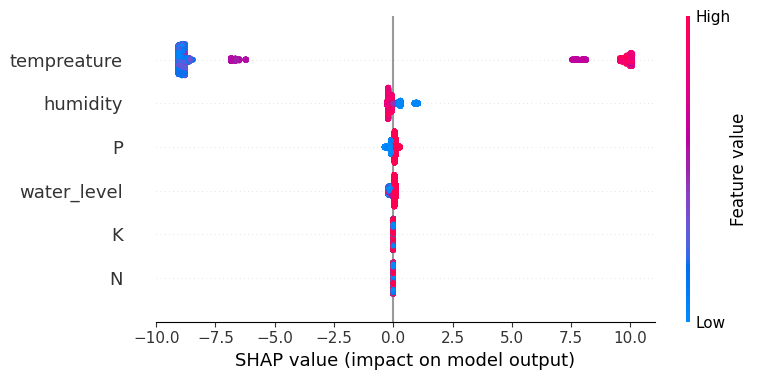

In [32]:
import shap
import matplotlib.pyplot as plt

# Use the first classifier from MultiOutput (Fan_actuator_ON)
explainer = shap.Explainer(xgb_model.estimators_[0])
shap_values = explainer(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)


In [33]:
pip install onnxmltools skl2onnx


In [34]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Convert the first target model (fan)
rf_fan_model = rf_model.estimators_[0]
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

onnx_model = convert_sklearn(rf_fan_model, initial_types=initial_type)
with open("rf_fan_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [ ]:
import pandas as pd
import joblib
import time

# Load model (RF or XGBoost)
model = joblib.load('/content/rf_greenhouse_model.pkl')  # or xgb_greenhouse_model.pkl

# Example real-time loop (replace with actual sensor reading code)
while True:
    # Simulate reading from sensors (replace this with your actual sensor interface)
    sensor_data = {
        'tempreature': 31, # Corrected column name to match training data
        'humidity': 40,
        'water_level': 90,
        'N': 130,
        'P': 90,
        'K': 100
    }

    # Convert to DataFrame for prediction
    df_input = pd.DataFrame([sensor_data])

    # Predict actions
    prediction = model.predict(df_input)

    fan_on = bool(prediction[0][0])
    watering_on = bool(prediction[0][1])

    # Print or act
    print(f"Fan: {'ON' if fan_on else 'OFF'} | Watering: {'ON' if watering_on else 'OFF'}")

    # Send to GPIO, relay, or cloud if needed here...

    # Delay before next check (simulate real-time)
    time.sleep(5)

Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
Fan: ON | Watering: ON
